# Detect outliers (bad injections)

## Content
1. Load modules
2. Import data
3. Check for log scaled measurements and detect bad injections (set to nan later in analysis, adapted from Zimmermann et al., 2019)
4. Plot bad injection per strain and pool
5. (Remove bad injection in targeted (manually extracted) data

## 1. Load modules

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Import data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

# Load tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

targeted_ms_paths = glob.glob(\
    'curated_input/targeted_per_strain/*_input_targeted_*')
targeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                      for file in targeted_ms_paths]

untargeted_ms_paths = glob.glob(\
    'curated_input/untargeted_per_strain/*_input_untargeted_*')
untargeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in untargeted_ms_paths]

del(targeted_ms_paths, untargeted_ms_paths)

## 3. Check for log scaled measurements and detect bad injections

In [4]:
# Check bad injections in untargeted data
# (in targeted (= manually extracted) data only drugs are measured,
# considering all peaks is probably more suitable)
#------------------------------------------------

untargeted_qc_list = []
col_vec_list = []
outliers = []


# Note: Faster when plotting is commented out

for strain_df in untargeted_perS_list:
    
    #extract columns with intensity values
    strain_df_vals = strain_df.loc[:, strain_df.columns.str.endswith('(raw)')]
    
    #print(strain_df_vals.shape)
    #-> they all have 48 columns and using endswith('(raw))') is fine
    
    s = strain_df_vals.columns[0].rsplit('-', 3)[2]
    
    # # Check for log scaled values (checks if whole table is log scaled)
    # # log(1) = 0, missing values, that were set to 1 would become 0
    # if sum(sum(strain_df_vals.values == 0)) > 0 and \
    #         sum(sum(strain_df_vals.values > 100000)) < 1000:
    #             print( s, 'is likely to be log-scaled') 
    #             strain_df_vals = strain_df_vals.applymap(lambda x : 10**x)
                
    # # No table seems to be log scaled --> commented out
    
    # Set 1s to nans
    strain_df_vals = strain_df_vals.replace(to_replace = 1, value = float('nan'))
    strain_df_vals = strain_df_vals.astype('float64')
    
    # Remove bad injections 
    col_sums = strain_df_vals.sum(0)
    col_sd = col_sums.std()
    cutoff = np.mean(col_sums - (5*col_sd))
    
    col_vec = []
    for idx, val in enumerate(col_sums):
        if val < cutoff:
            print(strain_df_vals.columns[idx], \
                  'in', s, 'is considered as bad injection.')
            outliers.append([s, strain_df_vals.columns[idx]])
            col_vec.append('red')
        else:
            col_vec.append('white')

   
    # set outliers to nan: Deactivated! Instead flagging is used
    # strain_df_vals.loc[:,col_sums < cutoff] = float('nan')
    
    # add mass, rt and composite spec to keep that info
    strain_df_vals.loc[:,'Mass'] = strain_df.loc[:,'Mass']
    strain_df_vals.loc[:,'RT'] = strain_df.loc[:,'Retention Time']
    strain_df_vals.loc[:,'CompSpectrum'] = strain_df.loc[:,'CompositeSpectrum']
    
    
    untargeted_qc_list.append(strain_df_vals)
    col_vec_list.append(col_vec)


del(col_vec, idx, s, val, strain_df, strain_df_vals, col_sums, col_sd, cutoff)


# Save untargeted data after first qc and outlier removal

#for idx, strain_df in enumerate(untargeted_qc_list):
#    s = strain_df.columns[0].rsplit('-',3)[2]
#    strain_df.to_csv('intermed_results/01_noBadInjections/data/untargeted_per_strain/'+\
#                     str(idx+1).zfill(2)+'_input_untargeted_'+s+'.txt', sep = ';')

MZ002H-Pool18-P001B1-S005-T12(raw) in S005 is considered as bad injection.
MZ002H-Pool21-P001C1-S009-T00(raw) in S009 is considered as bad injection.
MZ002H-Pool10-P003A1-S028-T00(raw) in S028 is considered as bad injection.
MZ002H-Pool08-P003B2-S030-T12(raw) in S030 is considered as bad injection.
MZ002H-Pool21-P003C4-S036-T00(raw) in S036 is considered as bad injection.
MZ002H-Pool97-P004A4-S040-T12(raw) in S040 is considered as bad injection.
MZ002H-Pool20-P004B3-S043-T12(raw) in S043 is considered as bad injection.
MZ002H-Pool99-P004C3-S047-T12(raw) in S047 is considered as bad injection.
MZ002H-Pool97-P004C4-S048-T00(raw) in S048 is considered as bad injection.
MZ002H-Pool12-P005A3-S051-T12(raw) in S051 is considered as bad injection.
MZ002H-Pool13-P005A4-S052-T00(raw) in S052 is considered as bad injection.
MZ002H-Pool15-P005B2-S054-T12(raw) in S054 is considered as bad injection.
MZ002H-Pool97-P005C2-S058-T00(raw) in S058 is considered as bad injection.
MZ002H-Pool13-P006A3-S063

In [5]:
#Save list of outliers
outlier_df = pd.DataFrame(outliers, columns = ['strain', 'injection'])
outlier_df = outlier_df.set_index('injection')

outlier_df.to_csv('intermed_results/01_noBadInjections/'+
                  'outliers.txt', sep = ';')

# outlier_df.shape  # 19 bad injections

## 4. Plot bad injection per strain and pool

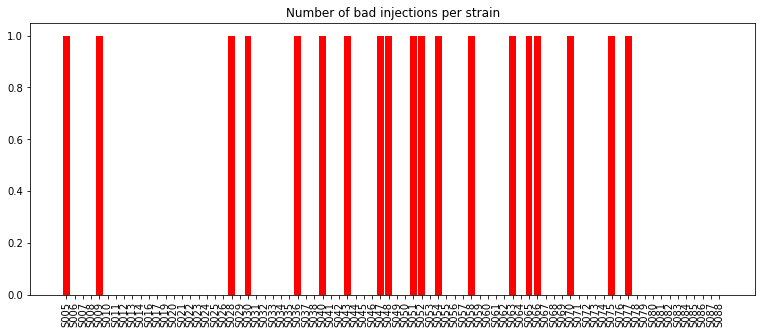

In [8]:
#%% Plot number of outliers per strain
stain_list = strain_info.index
out_strain_list = list(outlier_df['strain'])
out_count = []
for s in stain_list:
    if s in out_strain_list:
        out_count.append(out_strain_list.count(s))
    else:
        out_count.append(0)

       
plt.figure(figsize=(13,5))
plt.bar(stain_list, out_count, color = 'red') #, orientation='horizontal'
plt.xticks(rotation='vertical')
plt.title('Number of bad injections per strain')



#plt.savefig('intermed_results/01_noBadInjections/'+\
#                'bad_injection_per_strain.pdf',\
#                bbox_inches='tight')

plt.show()

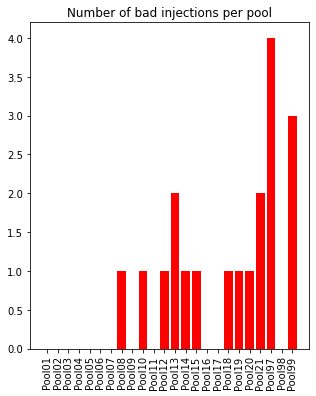

In [9]:
# Plot number of outliers per pool
    
pool_nums = list(range(1,22, 1))+[97, 98, 99]
pool_list = []
for p in pool_nums:
    pool_list.append('Pool'+str(p).zfill(2))
    
    
pool_out_count = []
out_injections = list(outlier_df.index)
for p in pool_list:
    p_count = 0
    for inject in out_injections:
        if p in inject:
            p_count = p_count+1
            
    pool_out_count.append(p_count)

       
plt.figure(figsize=(5,6))
plt.bar(pool_list, pool_out_count, color = 'red') #, orientation='horizontal'
plt.xticks(rotation='vertical')
plt.title('Number of bad injections per pool')

#plt.savefig('intermed_results/01_noBadInjections/'+\
#                'bad_injection_per_pool.pdf',\
#                bbox_inches='tight')

plt.show()

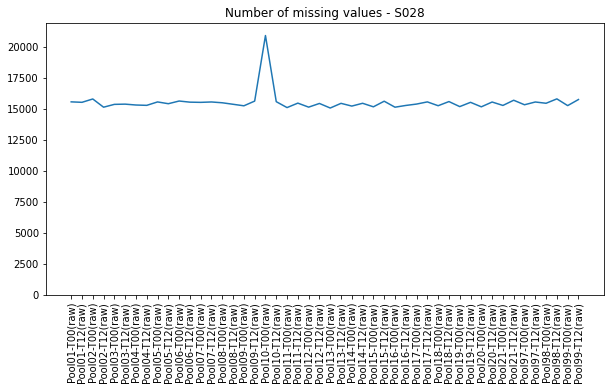

In [10]:
# Check how outliers look like (number of missing values) in example strain
#----------------------------------------------------------------------------

check_df = untargeted_perS_list[20]
check_df = check_df.replace(to_replace = 1, value = float('nan'))
check_df = check_df.iloc[:,:-6]

check_df.columns = [colname.rsplit('-', 5)[1] + '-' +\
                      colname.rsplit('-', 5)[4]\
                      for colname in check_df.columns]

data_points = check_df.isnull().sum(axis = 0)

plt.figure(figsize=(10,5))
plt.plot(data_points)
plt.ylim(0, max(data_points)+1000)
plt.xticks(rotation = 90)
plt.title('Number of missing values - S028')

# plt.savefig('intermed_results/01_noBadInjections/'+\
#                 'S028_miss_in_outlier.pdf',\
#                 bbox_inches='tight')

plt.show()

# plt.close('all')

# del(check_df, data_points)

## 5. (Remove bad injection in targeted (manually extracted) data)

In [6]:
# Remove bad injections based on untareted data in targeted tables
#---------------------------------------------------------------------

############################################################################
#  Only run for farmatting, bad injections are filtered out at later stage
############################################################################


targeted_qc_list = []
for s_table in targeted_perS_list:
    val_df = s_table.loc[:,s_table.columns.str.endswith('Area')]
    targeted_qc_list.append(val_df)

#stains_w_outliers = [x[0] for x in outliers]

#for i,_ in enumerate(targeted_qc_list):
#    s_table = targeted_qc_list[i].copy()
#    strain = s_table.columns[0].rsplit('-',3)[1]
#    if strain in stains_w_outliers:
#        out_idx = stains_w_outliers.index(strain)
#        pool = outliers[out_idx][1].split('-')[1]
#        timepoint = outliers[out_idx][1].split('-')[4][:3]
#        s_cols = s_table.columns
#        s_cols_p = [colname for colname in s_cols if pool in colname]
#        s_cols_pt = [colname for colname in s_cols_p if timepoint in colname]
#        s_table.loc[:,s_cols_pt] = np.float('nan')
#        targeted_qc_list[i] = s_table
        
#check_df = targeted_qc_list[0]

#%% Save targeted data after first qc and outlier removal


for idx, strain_df in enumerate(targeted_qc_list):
    s = strain_df.columns[0].rsplit('-',3)[1]
    strain_df.to_csv('intermed_results/01_noBadInjections/data/targeted_per_strain/'+\
                     str(idx+1).zfill(2)+'_input_targeted_'+s+'.txt', sep = ';') 
